In [1]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomCrop, MaxPooling2D, Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import BatchNormalization
from numpy import mean, std 
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Loading Hard Test Data

data_hard_test = np.load('data.npy') #Put your own Hard Test data .npy here with dimensions(90000,N)
labels_hard_test = np.load('labels.npy') #Put your own Hard Test Labels .npy here with dimensions(N)

print(data_hard_test.shape, labels_hard_test.shape)

(90000, 400) (400,)


In [2]:
import cv2
hard_test_data_length = data_hard_test.shape[1]
def load_hard_test_data(length):
    # load dataset
    data_rgb = []
    kernel = np.ones((4,4),np.uint8)
    for i in range(hard_test_data_length):
        data_rgb.append(data_hard_test[:,i].reshape(300,300))
        data_rgb[i] = cv2.medianBlur(data_rgb[i], 3)
        data_rgb[i] = cv2.morphologyEx(data_rgb[i], cv2.MORPH_OPEN, kernel)
        data_rgb[i] = cv2.resize(data_rgb[i], (50,50), interpolation=cv2.INTER_AREA)
    data_rgb = np.array(data_rgb)
    print(data_rgb.shape)
    
    # reshape dataset to have a single channel
    data_rgb = data_rgb.reshape((data_rgb.shape[0], 50,50, 1))
    
    # one hot encode target values
    labels = to_categorical(labels_hard_test)
    print(data_rgb.shape, labels.shape)
    return data_rgb, labels

In [3]:
# scale pixels
def prep_pixels(data):
    # convert from integers to floats
    data = data.astype('float32')
    
    # he_uniformize to range 0-1
    data_norm = (data) / 255.0
    
    # return he_uniformized images
    return data_norm

In [4]:
model = load_model('Final_CNN') #Loading our trained model

In [5]:
hard_test_data, hard_test_label = load_hard_test_data(hard_test_data_length)
    
# prepare pixel data
hard_test_data = prep_pixels(hard_test_data)

(400, 50, 50)
(400, 50, 50, 1) (400, 10)


### In the cell below, we are predicting the labels on our Hard Test set loaded above and using the threshold value to give the label '-1' which have probability less than threshold, as most of our unknown images will have max predicted probability for any label less than this threshold.

In [6]:
pred = model.predict(hard_test_data)
print(hard_test_label.shape, pred.shape)
prediction = []
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(hard_test_label, axis=1)
for i in range(hard_test_data_length):
    if max(pred[i]) < 0.8: # Max Threshold Probability for Unknown Images
        y_pred[i] = -1
    prediction.extend([y_true[i], y_pred[i]])
prediction = np.array(prediction)
prediction = np.reshape(prediction, (hard_test_data_length,2))
df = pd.DataFrame (prediction, columns = ['TRUE LABEL', 'LABEL PREDICTED'])
df #this dataframe conatins the true and predicted label for all images

(400, 10) (400, 10)


,TRUE LABEL,LABEL PREDICTED
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
395,5,5
396,6,6
397,7,7
398,8,8


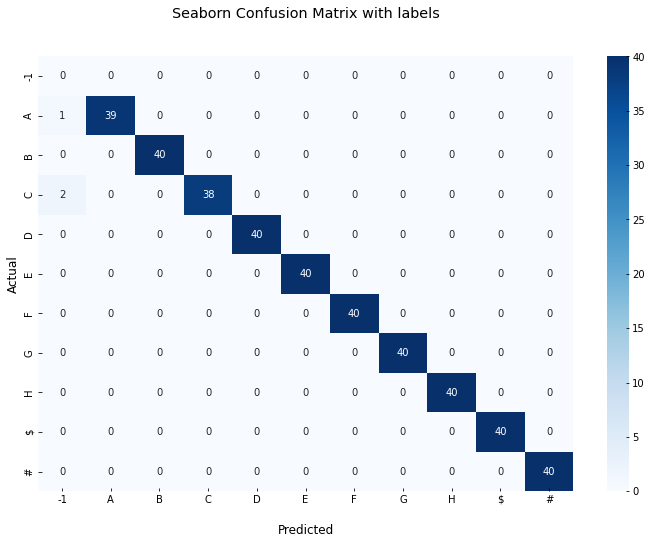

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
ax = sns.heatmap(confusion_matrix(y_true, y_pred), fmt='d', annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['-1','A','B','C','D','E','F','G','H','$','#'])
ax.yaxis.set_ticklabels(['-1','A','B','C','D','E','F','G','H','$','#'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [8]:
print("ACCUARCY : - ",accuracy_score(y_true, y_pred))

ACCUARCY : -  0.9925
